## Making A Markov Model to predict Daily Returns on Defi Protocols
The completed model should take 2 parameters: the length of short memory, and how many days to predict for

In [582]:
## imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import collections 

import itertools
from itertools import permutations

## get data from the csv
df = pd.read_csv("test_data.csv", index_col="day")
# clean df
index_len = len(df.index)
new_index = np.arange(0, index_len, 1)
df.index = new_index
df.index.rename('Day', inplace=True)

In [583]:
## Step 1. get daily return data for the crypto currencies
## later: get correlation coefs between the currencies so that they can be
## trained on each other's data

df = df.pct_change()

uniswap = df['uniswap'].values[1:]

frax = df['frax'].values[1:]

aave = df['aave'].values[1:]

dai = df['dai'].values[1:]

chainlink = df['chainlink'].values[1:]

maker = df['maker'].values[1:]

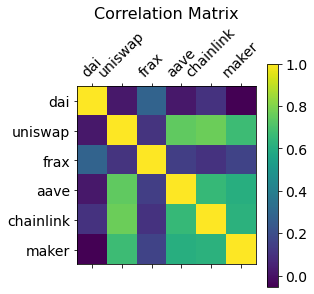

In [584]:
## correlation coefficients

plt.matshow(df.iloc[1:].corr())

plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

plt.show()

In [585]:
## Step 2. init Markov Class

class Markov:
    ## this class builds a markov model

    freqs1 = {} ## tuple: integer
    freqs2 = {} ## tuple: dict

    def __init__(self, order, training_data):
        self.k = order
        self.past_rets = training_data
        self.days = len(self.past_rets)
        self.freqs1 = {} ## tuple: integer
        self.freqs2 = {} ## tuple: list of integers

        ## pad ending of retun array
        for i in range(0, self.k):
            self.past_rets = np.append(self.past_rets, self.past_rets[-1])

        for i in range(0, self.days):
            kgram = tuple(np.round(self.past_rets[i:i + self.k], 2))
            # print(kgram)
            ## if pattern of returns doesn't exist yet
            if not kgram in self.freqs1:
                self.freqs1[kgram] = 0
                self.freqs2[kgram] = {}
            
            ## if kgram already exists
            self.freqs1[kgram] += 1

            ## get following day's return
            following_return = self.past_rets[i + self.k]
            
            ## don't over fit the model, use some rounding
            following_return = np.round(following_return, 2)

            if not following_return in self.freqs2[kgram]:
                self.freqs2[kgram][following_return] = 0

            self.freqs2[kgram][following_return] += 1

    def __str__(self):
        return str(self.freqs2)

    def kgram_lookup_err(self, kgram):
        raise Exception(f'{kgram} does not exist in the historical data')

    def kgram_length_err(self, kgram, len):
        raise Exception(f'{kgram} is of length {len} when it should be of length {self.k}')

    def freq(self, kgram):
        if len(kgram != self.k):
            self.kgram_length_err(kgram, len(kgram))

        ## return freq
        if not kgram in self.freqs1:
            q = 0
        else:
            q = self.freqs1[kgram]

        return q

    def random(self, kgram):
        if len(kgram) != self.k:
            self.kgram_length_err(kgram, len(kgram))
        elif kgram not in self.freqs1:
            self.kgram_lookup_err(kgram)

        w = self.freqs2[kgram].values()

        ran = random.choices(list(self.freqs2[kgram].keys()),
        weights=w, k=1)

        return ran[0]

    def random_w(self, kgram, p, v, n):
        if len(kgram) != self.k:
            self.kgram_length_err(kgram, len(kgram))
        elif kgram not in self.freqs1:
            self.kgram_lookup_err(kgram)

        v = int(v)

        w = self.freqs2[kgram].values()
        # print(w)
        
        final_w = np.zeros(len(w))

        # print('empty final w: ' + final_w)

        for i, val in enumerate(w):
            s = np.sign(list(self.freqs2[kgram].keys())[i])
            s = int(s)
            if s == v:
                final_w[i] = val * p[s + 1][n]
            else:
                final_w[i] = val * p[v + 1][n - 1]
            

        # print(f'1 final_w is len {final_w.shape[0]} and {final_w}')

        # print(list(w))

        final_w = 0.75 * final_w + 0.25 * np.asarray(list(w))

        # print(f'final_w is len {final_w.shape[0]} and {final_w}')

        ran = random.choices(list(self.freqs2[kgram].keys()),
        weights=final_w, k=1)
        # print(ran)
        return ran[0] 


In [586]:
## test Markov class

# m = Markov(2, uniswap)
# print(m)

In [587]:
## Step 3. implement return generator
def was_repeating(pred_list):
    ## how long has the last value been repeating in the list

    days = len(pred_list)

    if days < 2:
        return 0

    val = pred_list[-1]
    repetitions = 0
    for i in range(0, days):
        if pred_list[-(i + 1)] == val:
            repetitions += 1
        else:
            return repetitions

    return repetitions


def consec_prop(n, rets_signs, val=1):
    ## return probability of n consecutive successes, based on return data
    ## ie for all periods of n days, what pct had all successes (pos ret rate)

    success_consec = [ val for i in range(0, n) ]

    successes = 0
    trials = len(rets_signs) - n + 1

    for i in range(0, trials):
        cond = all(rets_signs[i:i + n][0] == item for item in rets_signs[i:i + n])
        if rets_signs[i:i + n][0] == val and cond:
            successes += 1

    return np.float64(successes) / trials


def repeating_probs(rets):
    total_days = len(rets)
    p = np.zeros((3, total_days + 1))

    rets_signs = np.sign(np.round(rets, 2))

    for i, val in enumerate(p):
        for j, prob in enumerate(p[i]):
            if j < 2:
                p[i][j] = np.nan
            else:
                p[i][j] = consec_prop(j, rets_signs, i - 1)

    return p

def generate(k, t, coin):
    m = Markov(k, coin.rets)

    ## init state
    current = tuple(np.round(coin.rets[0:k], 2))
    
    predict = np.zeros(t)

    predict[0] = np.round(coin.rets[0], 2)

    for i in range(1, t - 1):
        if i > 0:
            # probability it will repeat again
            n = was_repeating(predict) + 1

            # is price going up or down
            v = np.sign(predict[-1])


            predict[i] = m.random_w(current, coin.p, v, n)
        else:
            predict[i] = m.random(current)

        current = tuple(current[1:] + (predict[i],))

    return predict


In [588]:
## init class for each coin
class DefiCoin:
    
    def __init__(self, name, returns, p):
        self.name = name
        self.rets = returns
        self.p = p

uniswap_coin = DefiCoin('uniswap', uniswap, repeating_probs(uniswap))

frax_coin = DefiCoin('frax', frax, repeating_probs(frax))

maker_coin = DefiCoin('maker', maker, repeating_probs(maker))

aave_coin = DefiCoin('aave', aave, repeating_probs(aave))

In [589]:

def plot_ap(data, prediction, t):
    fig, ax = plt.subplots()
    plt.plot(range(0, t + 1), data[:t + 1], label='actual')
    plt.plot(range(0, t), prediction[:t], label='predicted')
    ax.set_title('Actual vs Predicted Daily Returns')
    ax.legend()
    plt.tight_layout()
    plt.show()



In [590]:
# fig, ax = plt.subplots()
# plt.bar(range(0,212), uniswap_coin.p[1])

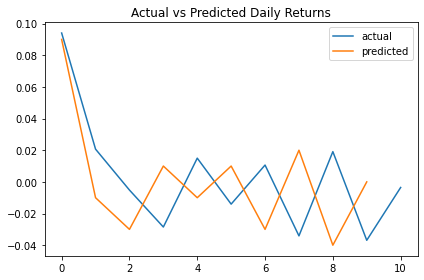

[[1.         0.47044286]
 [0.47044286 1.        ]]


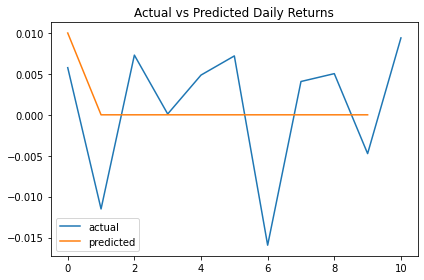

[[1.         0.23639014]
 [0.23639014 1.        ]]


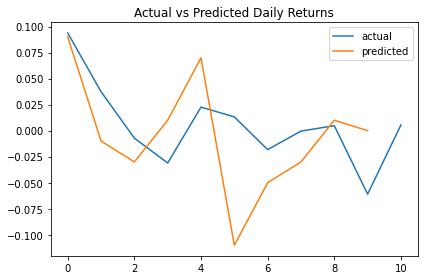

[[1.         0.43481349]
 [0.43481349 1.        ]]


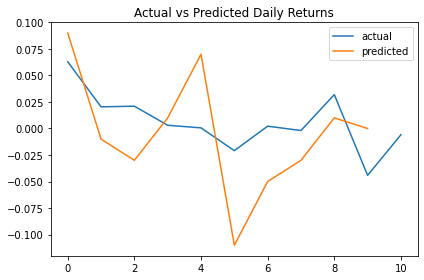

[[1.         0.11891396]
 [0.11891396 1.        ]]


In [591]:
predu = generate(2, 10, uniswap_coin)
predf = generate(2, 10, frax_coin)
preda = generate(2, 10, aave_coin)
predm = generate(2, 10, maker_coin)

plot_ap(uniswap, predu, 10)
print(np.corrcoef(uniswap[:10], predu))

plot_ap(frax, predf, 10)
print(np.corrcoef(frax[:10], predf))

plot_ap(aave, preda, 10)
print(np.corrcoef(aave[:10], preda))

plot_ap(maker, preda, 10)
print(np.corrcoef(maker[:10], predm))
